Import Library

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import branca.colormap as cm

from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
!pip install folium



Loading Dataset

In [2]:
df = pd.read_csv("/content/Case.csv")
df.head()


,case_id,province,city,group,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Yongsan-gu,True,Itaewon Clubs,139,37.538621,126.992652
1,1000002,Seoul,Gwanak-gu,True,Richway,119,37.48208,126.901384
2,1000003,Seoul,Guro-gu,True,Guro-gu Call Center,95,37.508163,126.884387
3,1000004,Seoul,Yangcheon-gu,True,Yangcheon Table Tennis Club,43,37.546061,126.874209
4,1000005,Seoul,Dobong-gu,True,Day Care Center,43,37.679422,127.044374


In [3]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0    case_id        174 non-null    int64 
 1   province        174 non-null    object
 2   city            174 non-null    object
 3   group           174 non-null    bool  
 4   infection_case  174 non-null    object
 5   confirmed       174 non-null    int64 
 6   latitude        174 non-null    object
 7   longitude       174 non-null    object
dtypes: bool(1), int64(2), object(5)
memory usage: 9.8+ KB


In [4]:
df.isnull().sum()



,0
case_id,0
province,0
city,0
group,0
infection_case,0
confirmed,0
latitude,0
longitude,0


Data Cleaning Latitude & Longitude

In [5]:
df = df.dropna(subset=['latitude', 'longitude'])



In [6]:
df['latitude'] = pd.to_numeric(df['latitude'], errors='coerce')
df['longitude'] = pd.to_numeric(df['longitude'], errors='coerce')
df = df.dropna(subset=['latitude', 'longitude'])


Visualisasi Awal

Heatmap Lokasi

In [62]:
from folium.plugins import HeatMap

m_heat = folium.Map(
    location=[df['latitude'].mean(), df['longitude'].mean()],
    zoom_start=10
)

HeatMap(df[['latitude','longitude']]).add_to(m_heat)
m_heat


Peta sebaran

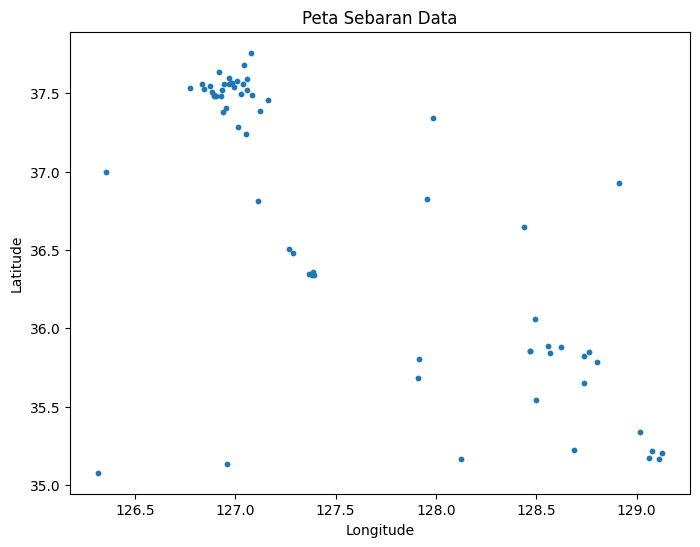

In [39]:
plt.figure(figsize=(8,6))
plt.scatter(df['longitude'], df['latitude'], s=10)
plt.title("Peta Sebaran Data")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()


Grafik Bar Total Kasus per Provinsi

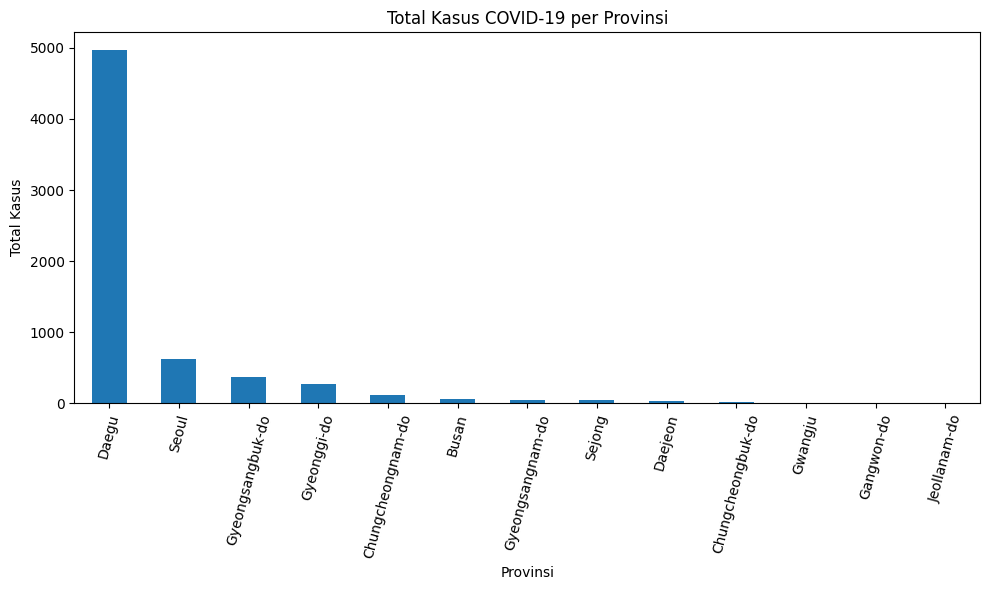

In [41]:
prov_col = 'province'
case_col = 'confirmed'

df_bar = df.groupby(prov_col)[case_col].sum().sort_values(ascending=False)

plt.figure(figsize=(10,6))
df_bar.plot(kind='bar')
plt.title("Total Kasus COVID-19 per Provinsi")
plt.xlabel("Provinsi")
plt.ylabel("Total Kasus")
plt.xticks(rotation=75)
plt.tight_layout()
plt.show()



Top 5 Provinsi Kasus terbanyak

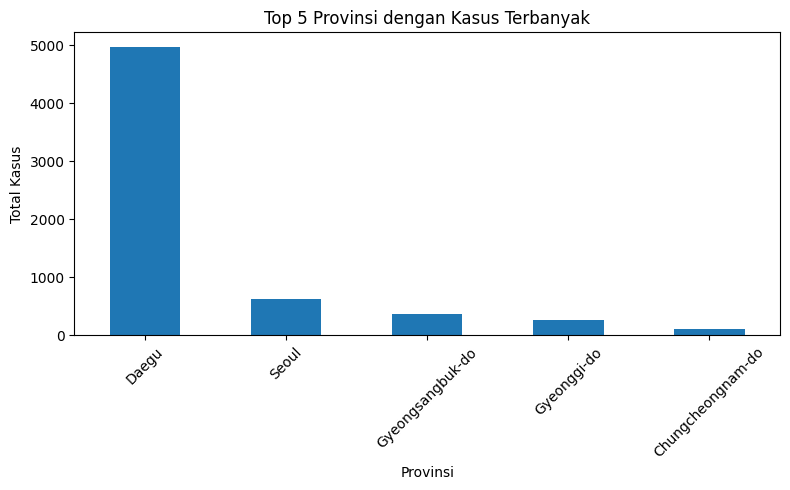

In [43]:
top5 = df_bar.head(5)

plt.figure(figsize=(8,5))
top5.plot(kind='bar')
plt.title("Top 5 Provinsi dengan Kasus Terbanyak")
plt.xlabel("Provinsi")
plt.ylabel("Total Kasus")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Analisis Korelasi Spearman

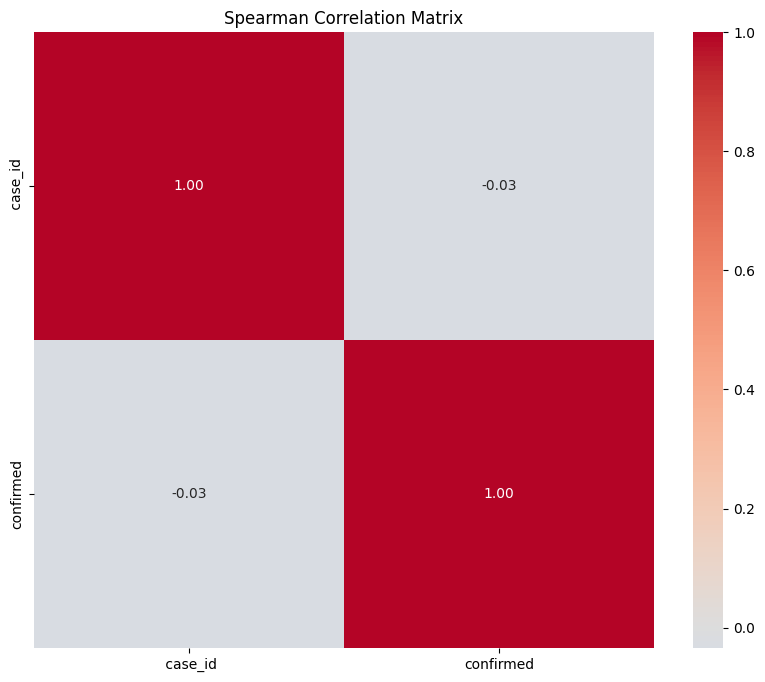

In [44]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()

corr_cols = [c for c in num_cols if c not in ['latitude', 'longitude']]
corr_df = df[corr_cols].copy()

spearman_r = corr_df.corr(method='spearman')

plt.figure(figsize=(10,8))
sns.heatmap(spearman_r, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Spearman Correlation Matrix")
plt.show()


Kolerasi Spesifik

In [56]:
# Korelasi spesifik: Latitude vs Confirmed
corr_lat_confirmed = df[['latitude', 'confirmed']].corr(method='spearman')

print("Korelasi Spearman Latitude vs Confirmed:")
print(corr_lat_confirmed)


Korelasi Spearman Latitude vs Confirmed:
           latitude  confirmed
latitude   1.000000   0.025356
confirmed  0.025356   1.000000


Visualisasi Speasiik LAt & long

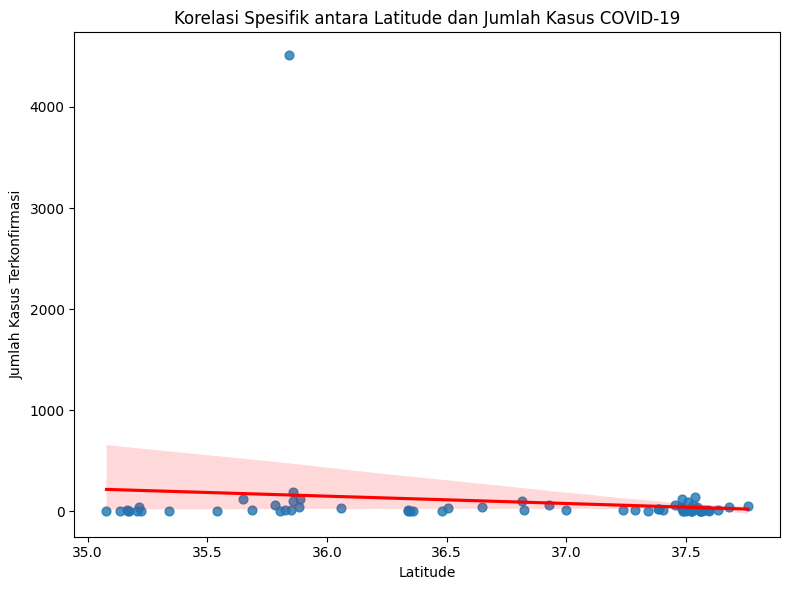

In [57]:
plt.figure(figsize=(8,6))
sns.regplot(
    x=df['latitude'],
    y=df['confirmed'],
    scatter_kws={'s':40},
    line_kws={'color':'red'}
)

plt.title("Korelasi Spesifik antara Latitude dan Jumlah Kasus COVID-19")
plt.xlabel("Latitude")
plt.ylabel("Jumlah Kasus Terkonfirmasi")
plt.tight_layout()
plt.show()


Normalisasi Data (Scaling)

In [45]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
coords_scaled = scaler.fit_transform(df[['latitude','longitude']])


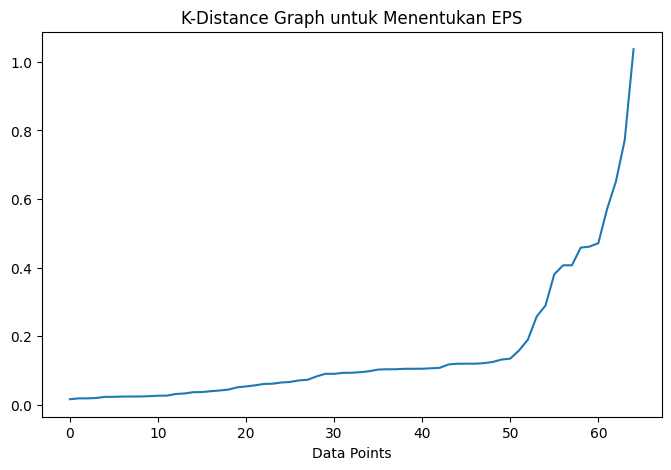

In [46]:
neigh = NearestNeighbors(n_neighbors=5)
nbrs = neigh.fit(coords_scaled)
distances, indices = nbrs.kneighbors(coords_scaled)
distances = np.sort(distances[:,4])

plt.figure(figsize=(8,5))
plt.plot(distances)
plt.title("K-Distance Graph untuk Menentukan EPS")
plt.xlabel("Data Points")
plt.show()


Menentukan Parameter DBSCAN

In [47]:
eps = 0.5
min_samples = 5


Train Test Split

In [48]:
X = coords_scaled

X_train, X_test = train_test_split(
    X, test_size=0.2, random_state=42
)


Proses Clustering DBSCAN

In [49]:
db_train = DBSCAN(eps=eps, min_samples=min_samples)
label_train = db_train.fit_predict(X_train)

db_test = DBSCAN(eps=eps, min_samples=min_samples)
label_test = db_test.fit_predict(X_test)


Gabung Data Train & Test

In [61]:
df_copy = df.copy().reset_index(drop=True)

X_train_idx, X_test_idx = train_test_split(
    df_copy.index, test_size=0.2, random_state=42
)

df_copy.loc[X_train_idx, 'cluster'] = label_train
df_copy.loc[X_test_idx, 'cluster']  = label_test

df_copy.loc[X_train_idx, 'set'] = 'Train'
df_copy.loc[X_test_idx,  'set'] = 'Test'

df_map = df_copy[['latitude','longitude','cluster','set']].rename(
    columns={'latitude':'lat', 'longitude':'lon'}
)

Evaluasi Model (Silhouette Score)

In [51]:
sil_score = silhouette_score(X_train, label_train)
print("Silhouette Score DBSCAN:", sil_score)


Silhouette Score DBSCAN: 0.3782215657942041


Visualisasi PCA

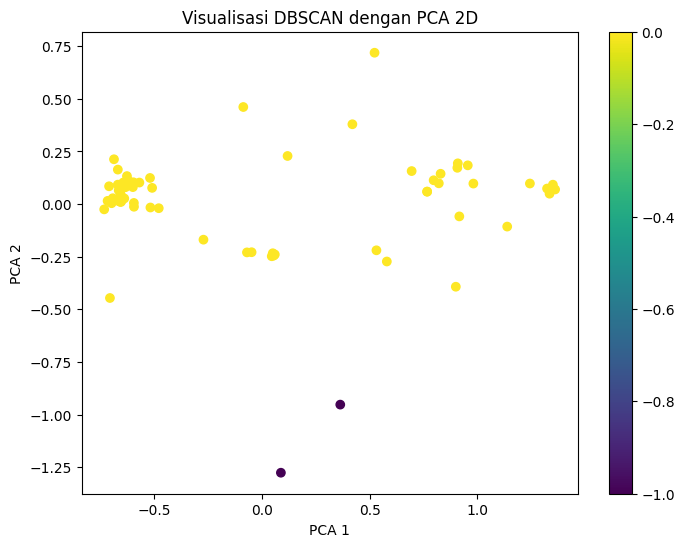

In [53]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(coords_scaled)

plt.figure(figsize=(8,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=DBSCAN(eps=eps, min_samples=min_samples).fit_predict(coords_scaled))
plt.title("Visualisasi DBSCAN dengan PCA 2D")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.colorbar()
plt.show()

Peta DBSCAN (Folium)

In [60]:
import folium
from folium.plugins import MarkerCluster
from IPython.display import display

m = folium.Map(
    location=[df_map['lat'].mean(), df_map['lon'].mean()],
    zoom_start=5
)

marker_cluster = MarkerCluster().add_to(m)

colors = {
    -1: 'black',
     0: 'red',
     1: 'blue',
     2: 'green',
     3: 'purple',
     4: 'orange'
}

for _, row in df_map.iterrows():
    cluster_id = row['cluster']
    color = colors.get(cluster_id, 'gray')

    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=5,
        color=color,
        fill=True,
        fill_color=color,
        fill_opacity=0.7,
        popup=f"Cluster: {cluster_id} | {row['set']}"
    ).add_to(marker_cluster)

display(m)


Menyimpan Peta

In [55]:
m.save("hasil_dbscan_peta.html")
